## Проект e-learning: вариант 2

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

Для начала загрузим все имеющиеся данные

In [2]:
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
SA = pd.read_csv('studentAssessment.csv')
SR = pd.read_csv('studentRegistration.csv')

Для определения того, что считается курсом, поизучаем датасет с названием courses

In [3]:
courses.isnull().sum().sum()

0

Пропусков в данных нет, уже хорошо, идем дальше <br>
Из описания: 
- code_module — предмет (идентификационный код).
- code_presentation — семестр (идентификационный код).
- module_presentation_length — продолжительность семестра в днях. <br>

Сгруппируем по предмету и семестру, подсчитаем сколько было каждого предмета в каждом семестре

In [4]:
courses.groupby(['code_module','code_presentation']).agg({'module_presentation_length': 'count'})

module_presentation_length
code_module code_presentation                            
AAA         2013J                                       1
            2014J                                       1
BBB         2013B                                       1
            2013J                                       1
            2014B                                       1
            2014J                                       1
CCC         2014B                                       1
            2014J                                       1
DDD         2013B                                       1
            2013J                                       1
            2014B                                       1
            2014J                                       1
EEE         2013J                                       1
            2014B                                       1
            2014J                                       1
FFF         2013B                                       1
            2013J                                       1
            2014B                                       1
            2014J                                       1
GGG         2013J                                       1
            2014B                                       1
            2014J                                       1

Каждый предмет встречался в семестре по одному разу.<br>
Из описания: обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест и что обычно только экзамены имеют вес 100, мы конечно это проверим, поэтому изучим дополнительно файл с оценками 

In [5]:
assessments.query('weight == 100').groupby('assessment_type').agg({'id_assessment': 'count'})

,id_assessment
assessment_type,
Exam,24


Что ж, не обманули, дальше будем изучать только предметы с экзаменами, точно ли по каждому предмету в одном семестре был только один экзамен?

In [6]:
assessments.query('weight == 100').groupby(['code_module','code_presentation']).agg({'id_assessment': 'count'})

id_assessment
code_module code_presentation               
AAA         2013J                          1
            2014J                          1
BBB         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
CCC         2014B                          2
            2014J                          2
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
EEE         2013J                          1
            2014B                          1
            2014J                          1
FFF         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
GGG         2013J                          1
            2014B                          1
            2014J                          1

Существует предмет ССС, по которым в один семестр было два экзамена, изучим его подробнее:

In [7]:
assessments.query('weight == 100 and code_module == "CCC"')\
            .groupby(['code_module','code_presentation', 'id_assessment'])\
            .agg({'id_assessment': 'count'})

id_assessment
code_module code_presentation id_assessment               
CCC         2014B             24290                      1
                              40087                      1
            2014J             24299                      1
                              40088                      1

Хмм, пора подключать к исследованию оценки студентов, сдавал ли кто-то эти 2 экзамена

In [8]:
SA_assessments = SA.merge(assessments, on = 'id_assessment')

In [9]:
SA_assessments.query('weight == 100 and code_module == "CCC"')\
             .groupby(['code_module','code_presentation', 'id_assessment'])\
             .agg({'id_student': 'count'})

id_student
code_module code_presentation id_assessment            
CCC         2014B             24290                 747
            2014J             24299                1168

Получается, что студенты сдавали по ССС только тесты 24290 и 24299

In [10]:
SA_assessments.query('weight == 100')\
             .groupby(['code_module','code_presentation', 'id_assessment'])\
             .agg({'id_student': 'count'})

id_student
code_module code_presentation id_assessment            
CCC         2014B             24290                 747
            2014J             24299                1168
DDD         2013B             25340                 602
            2013J             25354                 968
            2014B             25361                 524
            2014J             25368                 950

Курсом будем считать один предмет за семестр, по которому был экзамен у студентов

###  1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене)

Из описания к заданию: оценка ниже 40 неудачная/неуспешная сдача теста, следовательно оценка выше - успешная сдача 

Отфильтруем значения по типу теста, нас интересуют экзамены

In [11]:
exams = assessments.query('assessment_type == "Exam"')[['code_module', 'code_presentation', 'id_assessment']]
#Берем только эти столбцы, потому что оотальные для дальнейшего исследования не нужны
#Weight и Assesment_type будут везде одинаковые

Смержим таблицы с результатами экзаменов и информацией об экзаменах

In [12]:
SA_exams = SA.merge(exams, on = 'id_assessment')
SA_exams.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation
0,24290,558914,230,0,32.0,CCC,2014B
1,24290,559706,234,0,78.0,CCC,2014B
2,24290,559770,230,0,54.0,CCC,2014B
3,24290,560114,230,0,64.0,CCC,2014B
4,24290,560311,234,0,100.0,CCC,2014B


Проверим есть ли в данных пропуски

In [13]:
SA_exams.isnull().sum()

id_assessment        0
id_student           0
date_submitted       0
is_banked            0
score                0
code_module          0
code_presentation    0
dtype: int64

In [14]:
#отфильтруем только успешную сдачу экзаменов
passed_exam = SA_exams.query('score >= 40')

In [15]:
#количество уникальных студентов, успешно сдавших экзамены 
passed_exam.id_student.nunique() 

4097

Стоит проверить есть ли среди студентов те, кто сдавал более одного экзамена

In [16]:
students_exam = passed_exam.groupby('id_student') \
                .agg({'id_assessment':'count'}) \
                .reset_index()\
                .rename(columns = {'id_assessment':'number_of_exams'}) \
                .sort_values('number_of_exams', ascending = False)
students_exam.head()

,id_student,number_of_exams
2048,592093,2
755,445917,2
1303,543788,2
1881,582879,2
769,447644,2


Из получившейся таблицы видно, что есть студенты, сдавшие более одного экзамена, посчитаем сколько студентов сдавали только один экзамен

In [17]:
students_exam.query('number_of_exams == 1').shape

(3802, 2)

**3802** студента сдавали только один экзамен

---

### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*
_*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен_


In [18]:
#Проверим были ли перезачеты, так как значения либо 0, либо 1 можно посчитать сумму
#Если было бы не ноль, разбирались бы дальше с перезачетами
SA_exams.is_banked.sum()

0

In [19]:
# Количество всех попыток
all_tries = SA_exams.groupby(['code_module', 'code_presentation','id_assessment']) \
                    .agg({'id_assessment' : 'count'}) \
                    .rename(columns = {'id_assessment':'number_of_exams'}) \
                    .reset_index()

In [20]:
# Количество успешных попыток
succesful_tries = passed_exam.groupby(['code_module', 'code_presentation', 'id_assessment']) \
                            .agg({'id_assessment' : 'count'})\
                            .rename(columns = {'id_assessment':'number_of_exams'}) \
                            .reset_index()

In [21]:
# Завершаемость курса в процентах
all_tries['course_completion'] = round((succesful_tries.number_of_exams / all_tries.number_of_exams)*100,2)

In [22]:
all_tries.sort_values(by = 'course_completion')

,code_module,code_presentation,id_assessment,number_of_exams,course_completion
2,DDD,2013B,25340,602,83.72
1,CCC,2014J,24299,1168,87.24
5,DDD,2014J,25368,950,88.63
0,CCC,2014B,24290,747,88.89
3,DDD,2013J,25354,968,90.70
4,DDD,2014B,25361,524,92.56


По проценту завершаемости **самым сложным** был предмет DDD (тест 25340) в семестре 2013В, а **самым легким** оказался этот же предмет DDD (тест 25361) в семестре 2014В

Есть вероятность, успешная сдача зависит от сложности теста(id_assessment), сложности материала в данном семестре, уровня подготовленности и вовлечености студентов.

### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

In [23]:
passed_exam.drop_duplicates(['id_student'], keep = 'last') \
            .groupby(['code_module']).agg({'date_submitted' : 'mean'})\
            .round(2)\
            .rename(columns = {'date_submitted':'mean_time'}) \
            .reset_index()

,code_module,mean_time
0,CCC,239.14
1,DDD,237.98


Если решать в общем виде, то:<br>
- Среднее количество дней с начала семестра до сдачи экзамена по CCC - **239.14** <br>
- Среднее количество дней с начала семестра до сдачи экзамена по DDD - **237.98** <br>

Посмотрим на продолжительность курсов в таблице с информацией о курсах и выберем только интересующие нас курсы с экзаменами


In [24]:
courses.query('code_module == "DDD" or code_module == "CCC"')

,code_module,code_presentation,module_presentation_length
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262
10,DDD,2013B,240
11,DDD,2014B,241


Из данных по курсам нам видно, что один и тот же предмет в разных семестрах имеет разную продолжительность, возможно это влияет на среднее количество дней до сдачи, поэтому было решено считать средний срок сдачи экзаменов с группировкой и по семестрам

In [25]:
passed_exam.drop_duplicates(['id_student'], keep = 'last') \
            .groupby(['code_module', 'code_presentation', 'id_assessment']).agg({'date_submitted' : 'mean'})\
            .round(2)\
            .rename(columns = {'date_submitted':'mean_time'}) \
            .sort_values(by = 'mean_time')\
            .reset_index()

,code_module,code_presentation,id_assessment,mean_time
0,DDD,2013B,25340,230.17
1,CCC,2014B,24290,231.60
2,DDD,2014B,25361,234.94
3,DDD,2013J,25354,239.51
4,DDD,2014J,25368,242.80
5,CCC,2014J,24299,244.41


Картина уже немного меняется.

В целом видно, что студенты обычно сдают экзамены до окончания курса, но нужно доказать данными. Для этого смержим нашу таблицу с успешно сданными экзаменами с данными о курсах.

In [26]:
avg_exam_time = passed_exam.merge(courses, on = ['code_module', 'code_presentation'])

In [27]:
#Разница между продолжительностью курса и количеством дней с начала семестра до сдачи экзамена
avg_exam_time['diff_date'] = avg_exam_time.module_presentation_length - avg_exam_time.date_submitted

In [28]:
avg_exam_time.groupby(['code_module', 'code_presentation', 'module_presentation_length'])\
            .agg({'date_submitted' : 'mean', 'diff_date' : 'mean' })\
            .round(2)\
            .rename(columns = {'date_submitted':'mean_time'}) \
            .reset_index()

,code_module,code_presentation,module_presentation_length,mean_time,diff_date
0,CCC,2014B,241,231.58,9.42
1,CCC,2014J,269,244.40,24.60
2,DDD,2013B,240,230.16,9.84
3,DDD,2013J,261,239.51,21.49
4,DDD,2014B,241,234.94,6.06
5,DDD,2014J,262,242.80,19.20


В общем, получается, что студенты сдают экзамены заранее, но есть ли студенты, которые сдают экзамены после окончания?

In [29]:
avg_exam_time.query('diff_date <= 0').shape

(10, 9)

Оказывается есть, но их всего 10 

---
### 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3)

In [30]:
#Проверим данные на пропуски
SR.isnull().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

В данных есть пропущенные значения даты регистрации, вероятно были допущены какие-то ошибки, не осуждаем, но данные не будем использовать для дальнейшего анализа

In [31]:
SR = SR.dropna(subset = ['date_registration']) 

Узнаем самые популярные курсы за все время

In [32]:
most_popular = SR.groupby(['code_module'])\
  .agg({'date_registration':'count', 'date_unregistration':'count'})\
  .rename(columns = {'date_registration':'registrations_number', 'date_unregistration':'unregistrations_number'})\
  .reset_index()

most_popular.sort_values(by = 'registrations_number', ascending = False).head(3) # TOP-3

,code_module,registrations_number,unregistrations_number
1,BBB,7900,2369
5,FFF,7751,2370
3,DDD,6257,2223


Предмет BBB является лидером по подпискам

Посчитаем процент отписок от предметов

In [33]:
most_popular['churn_rate'] = round((most_popular.unregistrations_number / most_popular.registrations_number)*100, 2)

In [34]:
most_popular.sort_values(by = 'churn_rate', ascending = False).head(3)

,code_module,registrations_number,unregistrations_number,churn_rate
2,CCC,4426,1940,43.83
3,DDD,6257,2223,35.53
5,FFF,7751,2370,30.58


Предмет ССС является лидером по отпискам.

Так же можно заметить, что много отписок у предметов с большим количеством подписок. <br>
Например, предмет FFF занимает второе место по популярности и в то же время занимает 3 место по проценту оттока, а предмет DDD наоборот - 3 место по популярности и 2 по проценту оттока

In [35]:
most_popular.sort_values(by = 'unregistrations_number', ascending = False)

,code_module,registrations_number,unregistrations_number,churn_rate
5,FFF,7751,2370,30.58
1,BBB,7900,2369,29.99
3,DDD,6257,2223,35.53
2,CCC,4426,1940,43.83
4,EEE,2932,716,24.42
6,GGG,2534,289,11.40
0,AAA,748,126,16.84


Так же есть предмет GGG, может и не самый популярный, зато процент оттока минимальный

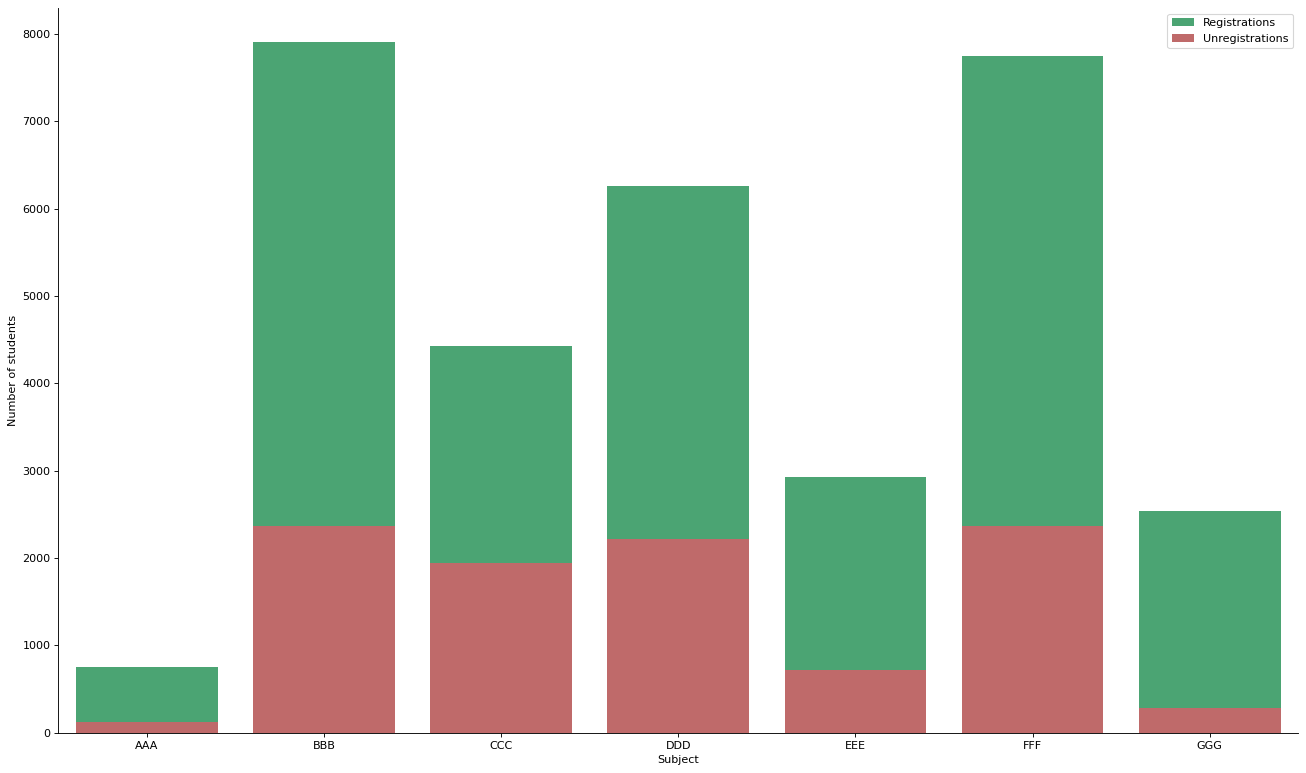

In [36]:
f, ax = plt.subplots(figsize=(20, 12), dpi= 80)

sns.barplot(x=most_popular.code_module, y=most_popular.registrations_number, label="Registrations", color='mediumseagreen')
sns.barplot(x=most_popular.code_module, y=most_popular.unregistrations_number, label="Unregistrations", color='indianred')

ax.legend()
ax.set(ylabel="Number of students", xlabel="Subject")

sns.despine()
plt.show()

### 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов

Самая низкая завершаемость была посчитана в рамках второго вопроса, здесь же информация продублирована с небольшим изменением, группировка выполнена только по семестру для более удобного восприятия итоговой таблицы

In [37]:
presentation = avg_exam_time.drop_duplicates(['id_student'], keep = 'last') \
            .groupby(['code_presentation']).agg({'date_submitted' : 'mean'})\
            .rename(columns = {'date_submitted':'mean_time'}) \
            .reset_index()

In [38]:
all_tries_5 = SA_exams.groupby(['code_presentation']) \
                    .agg({'id_assessment' : 'count'}) \
                    .rename(columns = {'id_assessment':'number_of_exams'}) \
                    .reset_index()

In [39]:
succesful_tries_5 = passed_exam.groupby(['code_presentation']) \
                            .agg({'id_assessment' : 'count'})\
                            .rename(columns = {'id_assessment':'number_of_exams'}) \
                            .reset_index()

In [40]:
all_tries_5['course_completion'] = round((succesful_tries_5.number_of_exams / all_tries_5.number_of_exams)*100,2)

In [41]:
all_tries_5 = all_tries_5.drop(['number_of_exams'], axis=1) 
#убираем так же для более лаконичной таблички

In [42]:
presentation = presentation.merge(all_tries_5,on='code_presentation')

In [43]:
presentation

,code_presentation,mean_time,course_completion
0,2013B,230.166998,83.72
1,2013J,239.510274,90.70
2,2014B,233.131504,90.40
3,2014J,243.594220,87.87


Семестр с самой низкой завершаемостью курсов - **2013B** <br>
Семестр самыми долгими средними сроками сдачи курсов - **2014J**

---
###  6. Построй адаптированные RFM-кластеры студентов.
Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: <br> 
- R - среднее время сдачи одного экзамена, 
- F - завершаемость курсов, 
- M - среднее количество баллов, получаемое за экзамен. 

Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

В целом у нас есть таблица SA_exams по которой можно рассчитать RFM - кластер, нужно только немного её доработать

In [44]:
RFM = SA_exams.groupby(['id_student'])\
            .agg({'date_submitted': 'mean', 'score': 'mean'})\
            .rename(columns = {'date_submitted':'R', 'score': 'M'})\
            .reset_index()

Посчитаем завершаемость курсов для каждого студента

In [45]:
all_exams = SA_exams.groupby('id_student').agg({'score':'count'})
passed_exams = SA_exams.query('score >= 40').groupby('id_student').agg({'score':'count'})
F = (passed_exams.score / all_exams.score).reset_index()
F.score.unique()
RFM['F'] = F.score

In [46]:
RFM = RFM[['id_student', 'R', 'F', 'M']]
RFM.head()

,id_student,R,F,M
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0


In [47]:
RFM.F.unique()

array([1. , nan, 0.5])

По завершаемости курсов достаточно легко поделить на кластеры: <br>
- 1 -  Сданы все экзамены (1 или 2 (выше была таблица, где макс.количество экзаменов у одного студента было 2))
- 0.5 - Сдан один курс
- nan - Не сдан ни один курс

In [48]:
def F_score(x):
    if x == 1:      
        return 1
    elif x == 0.5:  
        return 2
    else:           
        return 3

In [49]:
RFM.M.describe()

count    4633.000000
mean       65.117958
std        20.470561
min         0.000000
25%        50.000000
50%        66.000000
75%        82.000000
max       100.000000
Name: M, dtype: float64

По среднему количеству баллов, получаемых за экзамене я решила поделить следующим образом:
- 0-39 баллов - не сдал (нужно было набрать минимум 40) <br>
_Далее взяла равные промежутки_
- 40-69 баллов - сдал 
- 70-100 баллов - сдал достаточно хорошо


In [50]:
def M_score(x):
    if x >= 70:      
        return 1
    elif x < 70 and x > 39:  
        return 2
    else:           
        return 3

In [51]:
RFM.R.describe()

count    4633.000000
mean      238.462227
std         5.653378
min       229.000000
25%       234.000000
50%       241.000000
75%       243.000000
max       285.000000
Name: R, dtype: float64

По среднему времени сдачи одного экзамена возьмем границы по квартилям:
- менее 234 - студенты, сдавшие экзамен сильно заранее
- 234-243 - основной поток студентов
- более 243 - студенты, сдающие позже остальных

In [52]:
def R_score(x):
    if x <= 234:      
        return 1
    elif x > 234 and x <= 243:  
        return 2
    else:           
        return 3

In [53]:
RFM['R_score'] = RFM.R.apply(lambda x: R_score(x))
RFM['F_score'] = RFM.F.apply(lambda x: F_score(x))
RFM['M_score'] = RFM.M.apply(lambda x: M_score(x))
RFM['RFM_score'] = RFM.R_score.map(str) + RFM.F_score.map(str) + RFM.M_score.map(str)

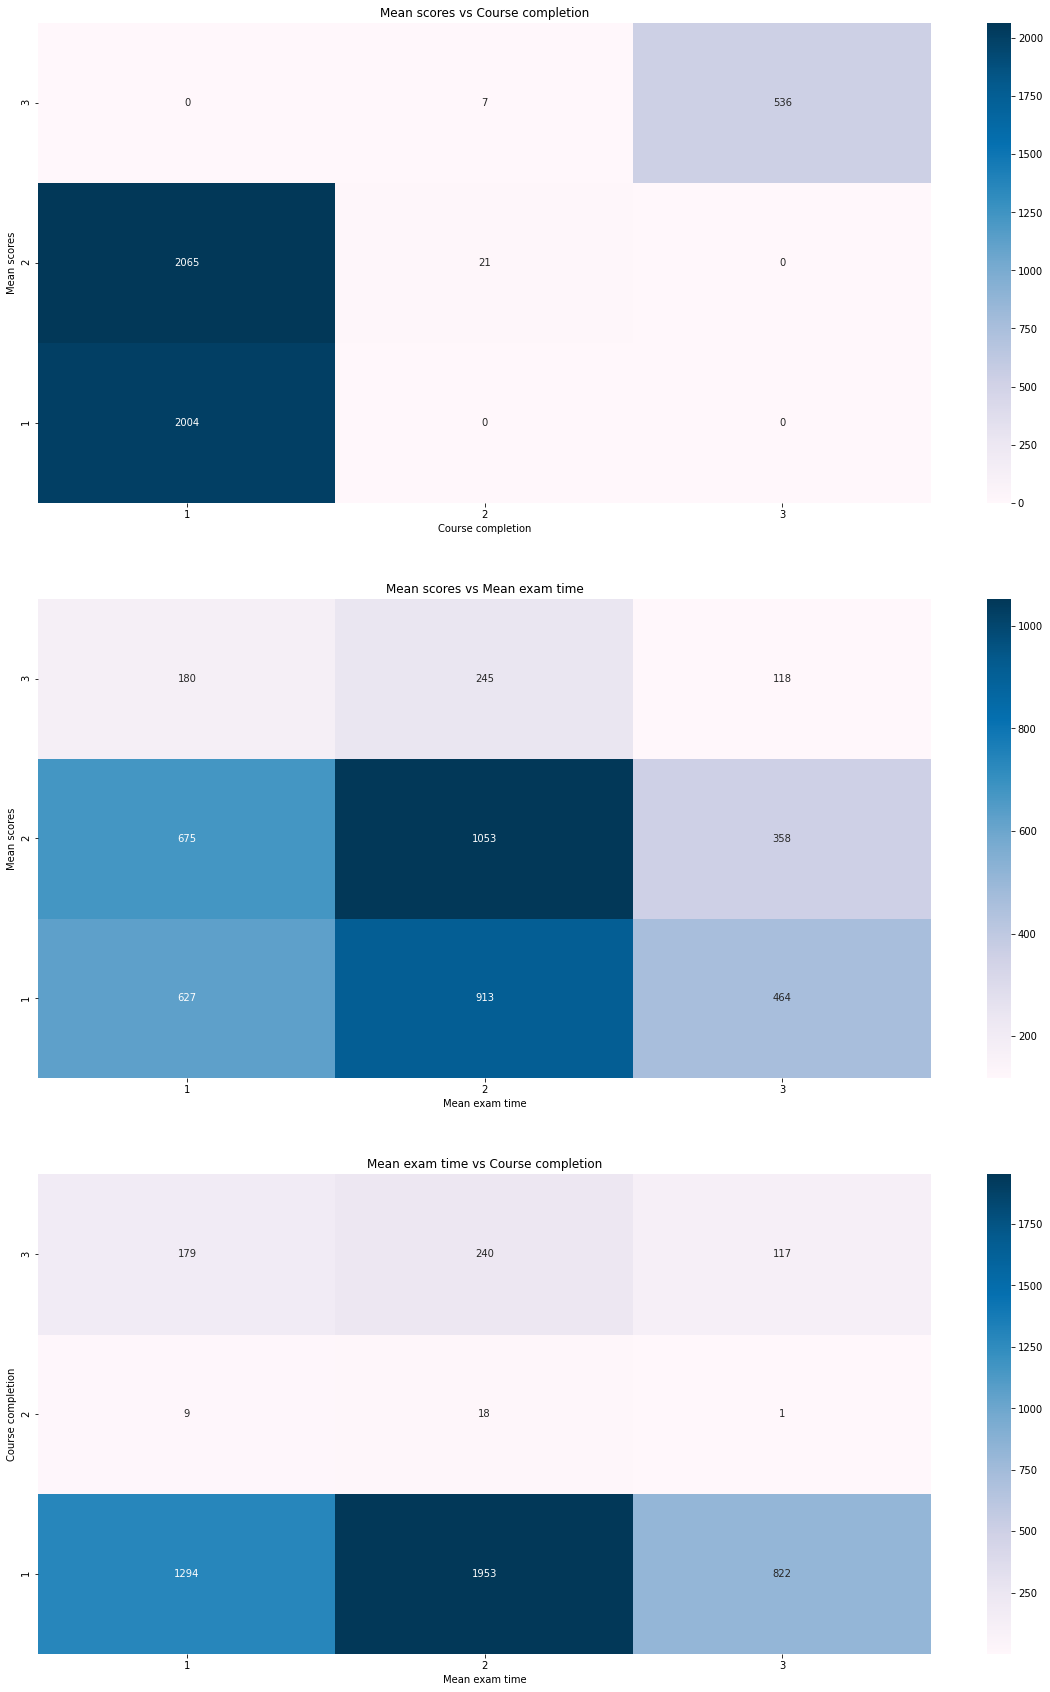

In [54]:
cross_table1 = pd.crosstab(index=RFM['M_score'], columns=RFM['F_score'])
cross_table2 = pd.crosstab(index=RFM['M_score'], columns=RFM['R_score'])
cross_table3 = pd.crosstab(index=RFM['F_score'], columns=RFM['R_score'])
plt.figure(figsize=(20,30))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='PuBu', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Mean scores')
ax1.set_xlabel('Course completion')
ax1.set_title('Mean scores vs Course completion')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='PuBu', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Mean scores')
ax2.set_xlabel('Mean exam time')
ax2.set_title('Mean scores vs Mean exam time')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='PuBu', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Course completion')
ax3.set_xlabel('Mean exam time')
ax3.set_title('Mean exam time vs Course completion')
plt.show()

Посмотрим сколько в каждом RFM-кластере студентов

In [55]:
RFM.groupby('RFM_score')\
    .agg({'id_student':'count'}).reset_index()

,RFM_score,id_student
0,111,627
1,112,667
2,122,8
3,123,1
4,133,179
5,211,913
6,212,1040
7,222,13
8,223,5
9,233,240


Получилось 14 сегментов, некоторые из них очень малочисленные, по графику выше Mean scores vs Course completion явно видно 5 групп, которые и были выделены:

In [56]:
segt_map = {
    r'11': 'Great',  # сдали с первого раза и средний балл выше 70 
    r'12': 'Good',   # сдали с первого раза и средний балл от 40 до 69
    r'22': 'Ok',     # сдали не с первого раза и средний балл от 40 до 69
    r'23': 'Bad',    # сдали не с первого раза и средний балл ниже 40
    r'33': 'Failed'  # не сдали 
}

RFM['Segment'] = RFM.F_score.map(str) + RFM.M_score.map(str)
RFM['Segment'] = RFM['Segment'].replace(segt_map, regex=True)
RFM.head()

,id_student,R,F,M,R_score,F_score,M_score,RFM_score,Segment
0,23698,243.0,1.0,80.0,2,1,1,211,Great
1,24213,236.0,1.0,58.0,2,1,2,212,Good
2,27116,243.0,1.0,96.0,2,1,1,211,Great
3,28046,237.0,1.0,40.0,2,1,2,212,Good
4,28787,243.0,1.0,44.0,2,1,2,212,Good


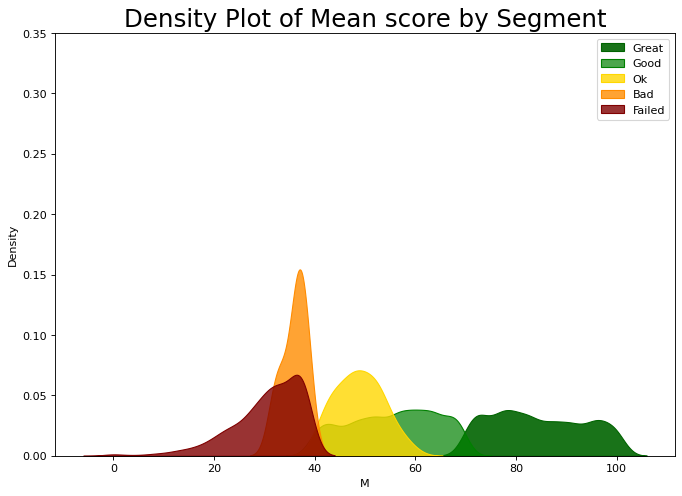

In [57]:
plt.figure(figsize=(10,7), dpi= 80)
sns.kdeplot(RFM.loc[RFM['Segment'] == 'Great', 'M'], color="darkgreen", label = 'Great', shade=True, alpha=.9)
sns.kdeplot(RFM.loc[RFM['Segment'] == 'Good', 'M'], color="green", label = 'Good', shade=True, alpha=.7)
sns.kdeplot(RFM.loc[RFM['Segment'] == 'Ok', 'M'], color="gold", label = 'Ok', shade=True, alpha=.8)
sns.kdeplot(RFM.loc[RFM['Segment'] == 'Bad', 'M'], color="darkorange", label = 'Bad', shade=True, alpha=.8)
sns.kdeplot(RFM.loc[RFM['Segment'] == 'Failed', 'M'], color="maroon", label = 'Failed', shade=True, alpha=.8)
plt.ylim(0, 0.35)


plt.title('Density Plot of Mean score by Segment', fontsize=22)
plt.legend()
plt.show()

In [58]:
#Подсчитываем сколько в каждом сегменте студентов и какую часть(процент) они занимают
rfm = RFM.groupby('Segment').agg({'id_student':'count'}).rename(columns = {'id_student':'number_of_students'}).reset_index()
rfm['part'] = round((rfm.number_of_students / rfm.number_of_students.sum())*100, 2)
rfm

,Segment,number_of_students,part
0,Bad,7,0.15
1,Failed,536,11.57
2,Good,2065,44.57
3,Great,2004,43.25
4,Ok,21,0.45


In [59]:
plt.figure(figsize=(13,13), dpi= 80)
fig = px.treemap(rfm, path=["Segment"], values='number_of_students',
                 color='number_of_students',
                 color_continuous_scale='pubu',
                 title='RFM segments')

fig.show()

<Figure size 1040x1040 with 0 Axes>

В целом, картина по студентам достаточно хорошая: <br>
- более 87% студентов успешно сдают экзамены с первого раза (Great+ Good)
- всего 0.45% пересдают экзамены, но успешно ( _в целом их можно отнести к 1 категории_ )
- 11.72% нужно обратить внимание на обучение или переосмыслить там ли они учатся, подходят ли им эти курсы (Bad+Failed) <br>

**Итог:** большинство студентов справляются с экзаменами (88.27%)